<a href="https://colab.research.google.com/github/magicznylukasz/uczenie_maszynowe_w_finansach/blob/main/case2_lz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Dane i biblioteki


## 1.1. Biblioteki

In [1]:
pip install surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise import accuracy


## 1.2. Wczytanie danych

In [3]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

# 2. Przegląd danych:

## 2.1. Liczba filmów Sci-Fi

In [4]:
# Wybierz filmy z gatunkiem Sci-Fi
scifi_movies = movies[movies['genres'].str.contains("Sci-Fi")]

# Oblicz liczbę filmów Sci-Fi
number_of_scifi_movies = scifi_movies.shape[0]

# Wyświetl informację o liczbie filmów Sci-Fi
print(f"Liczba filmów Sci-Fi: {number_of_scifi_movies}")

Liczba filmów Sci-Fi: 980


Całkowita liczba filmów Sci-Fi to 980

## 2.2. Rozkład ocen komedii

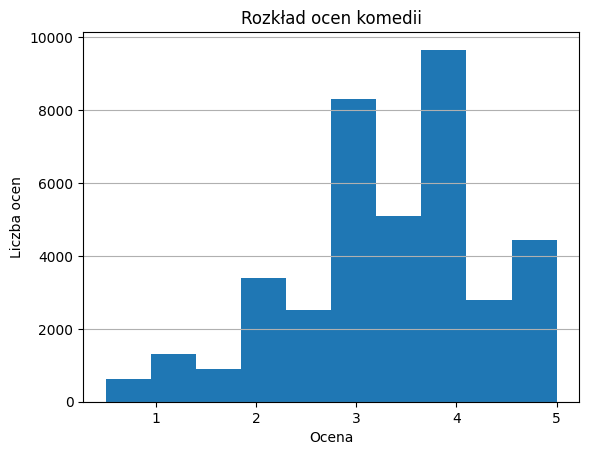

In [5]:
# Filtruj filmy komediowe
comedy_movies = movies[movies['genres'].str.contains("Comedy")]
comedy_ratings = ratings[ratings['movieId'].isin(comedy_movies['movieId'])]

# Pobierz oceny dla filmów komediowych
comedy_ratings_values = comedy_ratings['rating'].values

# Spróbuj przekonwertować oceny na wartości numeryczne przed wykreśleniem dystrybucji
try:
  # Jeśli jest to typ łańcuchowy, usuń wszystkie znaki poza liczbami, ".", "+" lub "-".
  if pd.api.types.is_string_dtype(comedy_ratings_values):
    for i in range(len(comedy_ratings_values)):
      comedy_ratings_values[i] = re.sub(r"[^\d\-+\.]", "", comedy_ratings_values[i])
  comedy_ratings_values = pd.to_numeric(comedy_ratings_values)
except:
  pass

# Wykreśl dystrybucję ocen z ustawionymi kategoriami dla skali od 1 do 10
plt.hist(comedy_ratings_values)  # Dostosuj krawędzie kategorii w razie potrzeby

plt.xlabel("Ocena")
plt.ylabel("Liczba ocen")
plt.title("Rozkład ocen komedii")
plt.grid(axis='y')

plt.show()


Powyżej wykres przedstawiający oceny filmów komediowych. Najczęstsza ocena to 4

## 2.3. Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej ocenianych

In [6]:
# Filtruj filmy akcji
action_movies = movies[movies['genres'].str.contains("Action")]

# Oblicz średnią ocenę dla wszystkich filmów akcji
average_rating_action = ratings[ratings['movieId'].isin(action_movies['movieId'])]["rating"].mean()

# Konwertuj średnią ocenę na sformatowany ciąg znaków z jednym miejscem po przecinku
average_rating_action_str = f"{average_rating_action:.1f}"

# Wydruk
print(f"Średnia ocena wszystkich filmów akcji: {average_rating_action_str}")

Średnia ocena wszystkich filmów akcji: 3.4


Średnia ocena filmów akcji to 3.4

In [7]:
# Posortuj oceny według oceny malejąco i wybierz pierwsze 3 wiersze (najwyżej ocenione filmy)
top_3_action_movies = ratings[ratings['movieId'].isin(action_movies['movieId'])].sort_values(by='rating', ascending=False).head(3)

# Połącz oceny i filmy na podstawie movieId, aby uwzględnić tytuły
top_3_action_movies = top_3_action_movies.merge(action_movies[['movieId', 'title']], how='inner', on='movieId')

# Wydruk
print(f"3 najwyżej oceniane filmy akcji:")
for i, row in top_3_action_movies.iterrows():
    print(f"{i+1}. {row['title']} (rating: {row['rating']:.1f})")

3 najwyżej oceniane filmy akcji:
1. Thing, The (1982) (rating: 5.0)
2. Star Wars: Episode VI - Return of the Jedi (1983) (rating: 5.0)
3. Star Wars: Episode VI - Return of the Jedi (1983) (rating: 5.0)


# 3. System rekomendacyjny

## 3.1. Sprawdzenie i przygotowanie danych

In [8]:
ratings.shape

(100836, 4)

In [9]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
print(f'Duplicate entries: {ratings.duplicated().sum()}')

Duplicate entries: 0


Rozkład ocen wszystkich filmów

In [12]:
rating_types = ratings['rating'].value_counts()
x,y   = rating_types.index, rating_types.values
data  = go.Bar(x=x,y=y, text=y, textposition="outside")
Layout=go.Layout(title="Count of ratings",xaxis={'title':'Rating'},yaxis={'title':'Count'})
go.Figure(data,Layout)

Liczba ocen, którą przyznali poszczególni użytkownicy

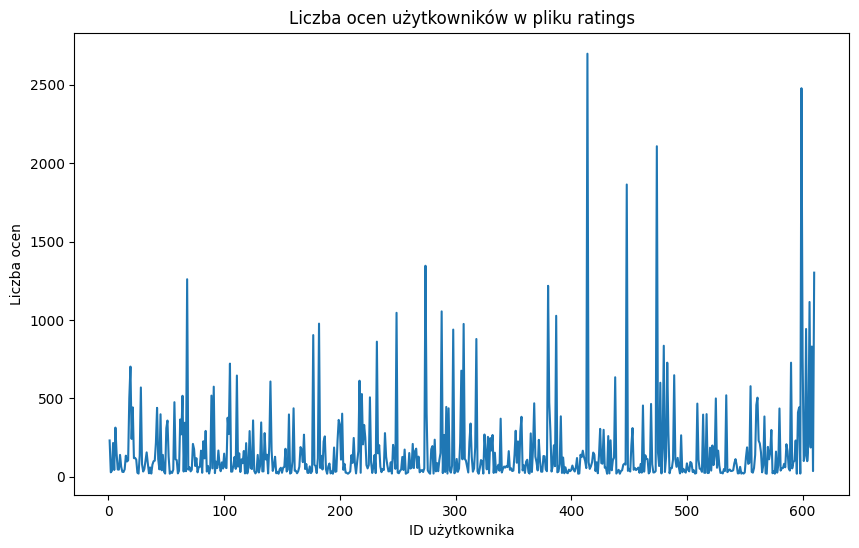

In [13]:
# Policz liczbę ocen dla każdego użytkownika
ilosc_ocen_uzytkownika = ratings.groupby('userId')['rating'].count()

# Utwórz wykres liniowy
plt.figure(figsize=(10, 6))
plt.plot(ilosc_ocen_uzytkownika.index, ilosc_ocen_uzytkownika.values)
plt.xlabel('ID użytkownika')
plt.ylabel('Liczba ocen')
plt.title('Liczba ocen użytkowników w pliku ratings')
plt.show()

In [14]:
# Pobierz 10 użytkowników z największą liczbą ocen
uzytkownicy_z_najwieksza_liczba_ocen = ratings.groupby('userId')['rating'].count().nlargest(10)

# Wyświetl dane
print(uzytkownicy_z_najwieksza_liczba_ocen)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: rating, dtype: int64


Liczba ocen, którą otrzymał dany film

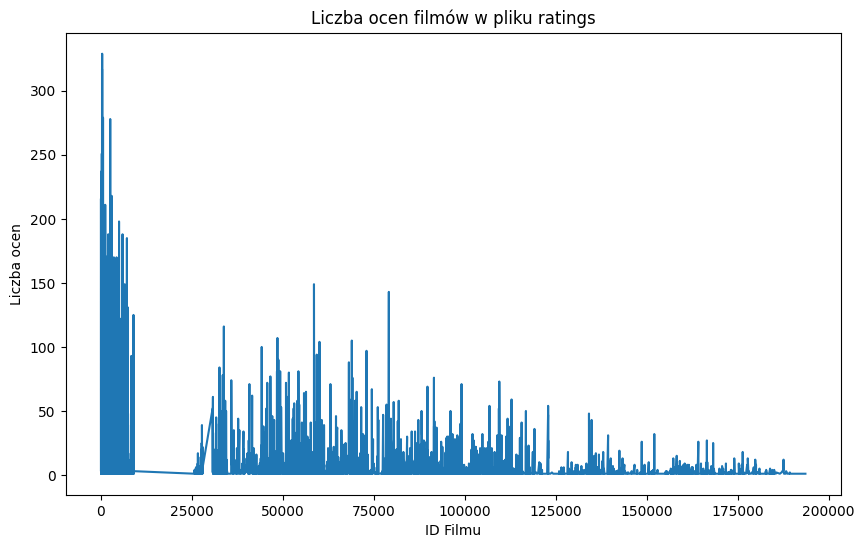

In [15]:
# Policz liczbę ocen dla każdego użytkownika
ilosc_ocen_filmow = ratings.groupby('movieId')['rating'].count()

# Utwórz wykres liniowy
plt.figure(figsize=(10, 6))
plt.plot(ilosc_ocen_filmow.index, ilosc_ocen_filmow.values)
plt.xlabel('ID Filmu')
plt.ylabel('Liczba ocen')
plt.title('Liczba ocen filmów w pliku ratings')
plt.show()

Z racji tego, że niektóre filmy otrzymały bardzo dużo ocen, a inne stosunkowo mało postawnowiłem ograniczyć ich liczebność. Do nowego zbioru danych zostały zaliczone wszystkie filmy, które uzyskały przynajmniej 25 ocen. Podobna sytuacja dotyczy użytkowników. W tym przypadku do nowego zbioru danych zaliczam takich co mają przynajmniej 250 ocen. Chciałbym żeby filmy, które posiadają mało ocen nie zaburzały rankingu i tak samo w przypadku użytkowników, gdzie wolę uwzględnić tych, którzy oglądają więcej filmów.

In [16]:
MIN_USER_RATINGS = 250
MIN_MOVIE_RATINGS = 25

# Wybierz użytkowników, którzy ocenili co najmniej MIN_USER_RATINGS filmów
frequent_users = ilosc_ocen_uzytkownika[ilosc_ocen_uzytkownika >= MIN_USER_RATINGS].index

# Wybierz filmy, które otrzymały co najmniej MIN_MOVIE_RATINGS ocen
frequent_movies = ilosc_ocen_filmow[ilosc_ocen_filmow >= MIN_MOVIE_RATINGS].index

# Filtrowanie ocen dla często oceniających użytkowników i często ocenianych filmów
filtered_ratings = ratings[ratings['userId'].isin(frequent_users) & ratings['movieId'].isin(frequent_movies)]

# Filtrowanie filmów dla często ocenianych filmów
filtered_movies = movies[movies['movieId'].isin(frequent_movies)]

filtered_ratings = ratings[ratings['userId'].isin(frequent_users) & ratings['movieId'].isin(frequent_movies)]

# Połączenie ocen z filmami, aby uzyskać tytuły i gatunki filmów
ratings_merge = filtered_ratings.merge(movies[['movieId', 'title', 'genres']], how='left', on='movieId')


print("Number of users after filtering:", len(frequent_users))
print("Number of movies after filtering:", len(filtered_movies))
print("Number of ratings after filtering:", len(filtered_ratings))

Number of users after filtering: 105
Number of movies after filtering: 1050
Number of ratings after filtering: 33370


In [17]:
print(f'Duplicate entries: {ratings_merge.duplicated().sum()}')

Duplicate entries: 0


In [18]:
ratings_merge.head(5)

,userId,movieId,rating,timestamp,title,genres
0,6,2,4.0,845553522,Jumanji (1995),Adventure|Children|Fantasy
1,6,3,5.0,845554296,Grumpier Old Men (1995),Comedy|Romance
2,6,5,5.0,845553938,Father of the Bride Part II (1995),Comedy
3,6,6,4.0,845553757,Heat (1995),Action|Crime|Thriller
4,6,7,4.0,845554264,Sabrina (1995),Comedy|Romance


## 3.2. Czym różni się algorytm kNN with means od standardowego kNN?

Główną różnicą między zwykłą metodą KNN, a KNN with means jest to, że w tej drugij oprócz wyboru k najbliższych sąsiadów, uwzględniamy również średnią ocenę dla elementów w zbiorze danych. W ten sposób algorytm kNN with Means może radzić sobie lepiej z przewidywaniem ocen dla nowych elementów, szczególnie gdy dane są niewystarczające dla konkretnych sąsiadów.

## 3.3. System oparty na KNN with means

In [21]:
# Tworzenie zbioru testowego i treningiwego
reader = Reader(rating_scale=(1, 5))
data   = Dataset.load_from_df(ratings_merge[['userId','title','rating']], reader)

raw_ratings = data.raw_ratings
import random
random.shuffle(raw_ratings)

threshold   = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold]
test_raw_ratings  = raw_ratings[threshold:]

data.raw_ratings = train_raw_ratings
trainset         = data.build_full_trainset()
testset          = data.construct_testset(test_raw_ratings)

In [22]:
# KNNWithMeans z poniższymi hiperparametrami

param_grid = {
    'sim_options': {
        'name': ['msd', 'cosine'],
        'min_support': [2, 6],
        'user_based': [False, True]
    },
    'k': list(range(2, 7))  #k - ilość sąsiadów od 2 do 6
}

gridsearchKNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1)

gridsearchKNNWithMeans.fit(data)

print(f'MAE Best Parameters:  {gridsearchKNNWithMeans.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchKNNWithMeans.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchKNNWithMeans.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchKNNWithMeans.best_score["rmse"]}\n')


MAE Best Parameters:  {'sim_options': {'name': 'msd', 'min_support': 2, 'user_based': True}, 'k': 6}
MAE Best Score:       0.6387480940227162

RMSE Best Parameters: {'sim_options': {'name': 'msd', 'min_support': 2, 'user_based': True}, 'k': 6}
RMSE Best Score:      0.830661575885047



Kroswalidacja, gdzie użyłem mae jako esytmator

In [23]:
knn_cv_results = cross_validate(gridsearchKNNWithMeans.best_estimator['mae'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8404  0.8442  0.8216  0.8227  0.8228  0.8303  0.0099  
MAE (testset)     0.6448  0.6438  0.6338  0.6329  0.6345  0.6379  0.0052  
Fit time          0.02    0.02    0.04    0.07    0.03    0.04    0.02    
Test time         0.18    0.39    0.48    0.88    0.19    0.42    0.26    


Kroswalidacja, gdzie użyłem rmse jako estymator

In [24]:
knn_cv_results = cross_validate(gridsearchKNNWithMeans.best_estimator['rmse'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8356  0.8208  0.8226  0.8322  0.8249  0.8272  0.0057  
MAE (testset)     0.6456  0.6296  0.6318  0.6423  0.6334  0.6365  0.0062  
Fit time          0.02    0.02    0.03    0.02    0.03    0.02    0.00    
Test time         0.17    0.18    0.31    0.18    0.16    0.20    0.06    


## 3.4. System oparty na SVD

In [25]:
# SVD z poniższymi hiperparametrami

param_grid = {"n_factors": range(10,100,20),
              "n_epochs" : [5, 10, 20],
              "lr_all"   : [0.002, 0.005],
              "reg_all"  : [0.2, 0.5]}

gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)

gridsearchSVD.fit(data)

print(f'MAE Best Parameters:  {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

MAE Best Parameters:  {'n_factors': 90, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
MAE Best Score:       0.6282865262471292

RMSE Best Parameters: {'n_factors': 90, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
RMSE Best Score:      0.8165512277550416



Kroswalidacja, gdzie użyłem mae jako esytmator

In [26]:
svd_cv_results = cross_validate(gridsearchSVD.best_estimator['mae'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8205  0.8059  0.8185  0.8242  0.8030  0.8144  0.0084  
MAE (testset)     0.6333  0.6166  0.6351  0.6283  0.6214  0.6269  0.0070  
Fit time          0.30    0.32    0.32    0.31    0.32    0.31    0.01    
Test time         0.03    0.03    0.03    0.04    0.03    0.03    0.00    


Kroswalidacja, gdzie użyłem rmse jako esytmator

In [27]:
svd_cv_results = cross_validate(gridsearchSVD.best_estimator['rmse'], data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8163  0.8162  0.8038  0.8061  0.8305  0.8146  0.0094  
MAE (testset)     0.6307  0.6266  0.6211  0.6207  0.6349  0.6268  0.0055  
Fit time          0.49    0.47    0.49    0.40    0.32    0.43    0.07    
Test time         0.05    0.05    0.24    0.03    0.03    0.08    0.08    


## 3.5. Omówienie wyników

Dla metody KNN with means i dla metody SVD została zastosowana pięciokrotna walidacja krzyżowa. Wyniki dla KNN i SVD są bardzo podobne. Największe odchylenie standardowe dla RMSE to 0.0099 odnotowane dla KNN with means, gdzie jako estymator było brane RMSE. Najmniejszy wynik odchylenia dla RMSE to 0.0057 dla KNN with means, przy estymatorze MAE. Podobnie niskie wartości odchylenia i innych wskaźników odnotować można dla MAE, fit time i test time. Można stwierdzić, że dokładność predykcji jest na bardzo wysokim poziomie, a czas do trenowania i testowania modelu jest krótki. Generalnie nie ma zbyt dużej różnicy między modelami i są one bardzo porównywalne przy zastosowanych parametrach

# 4. Podaj rekomendacje po obejrzeniu filmu: Jumanji  oraz Flint

## 4.1. Jumanji

Pozyskanie ID filmu Jumanji

In [28]:
def get_movieId_by_title(title):
  try:
    movieId = movies[movies['title'] == title]['movieId'].values[0]
    return movieId
  except IndexError:
    print(f"Movie with title '{title}' not found.")
    return None

search_title = "Jumanji (1995)"
movieId = get_movieId_by_title(search_title)

if movieId:
  print(f"movieId for '{search_title}': {movieId}")

movieId for 'Jumanji (1995)': 2


Sprawdzenie czy film Jumanji jest w wyselekcjonowanym zestawie danych

In [29]:
if 2 in ratings_merge['movieId'].values:
    print("Film o movieId 2 znajduje się w zestawie danych.")
else:
    print("Film o movieId 2 nie znajduje się w zestawie danych.")

Film o movieId 2 znajduje się w zestawie danych.


Rekomendacja oparta na gatunku filmu z wykorzystaniem modelu KNN

In [30]:
# Obejrzany film
watched_movie_id = 2

# Pobierz gatunki obejrzanego filmu
genres_of_watched_movie = movies.loc[movies['movieId'] == watched_movie_id, 'genres'].values[0].split('|')

# Wybierz filmy z tych samych gatunków co obejrzany film, ale inne niż obejrzany film
recommended_movies = ratings_merge[(ratings_merge['genres'].apply(lambda x: any(genre in x for genre in genres_of_watched_movie))) &
                                   (ratings_merge['movieId'] != watched_movie_id)]

# Utwórz zestaw danych dla rekomendacji
data_recommend = Dataset.load_from_df(recommended_movies[['userId', 'title', 'rating']], reader)

# Dopasuj model KNN z użyciem średnich wartości do rekomendacji
algo = KNNWithMeans(**gridsearchKNNWithMeans.best_params['mae'])  # Wybierz najlepsze parametry dla MAE
trainset_recommend = data_recommend.build_full_trainset()
algo.fit(trainset_recommend)

# Wygeneruj rekomendacje dla użytkownika na podstawie obejrzanego filmu
recommendations = algo.get_neighbors(watched_movie_id, k=10)  # Znajdź 10 podobnych filmów

# Wypisz rekomendacje
print("Rekomendowane filmy po obejrzeniu filmu o movieId =", watched_movie_id)
for movie_id in recommendations:
    movie_title = movies.loc[movies['movieId'] == movie_id, 'title']
    if not movie_title.empty:
        print(f"- {movie_title.values[0]}")
    else:
        print(f"- Brak informacji o tytule dla movieId = {movie_id}")

Computing the msd similarity matrix...
Done computing similarity matrix.
Rekomendowane filmy po obejrzeniu filmu o movieId = 2
- From Dusk Till Dawn (1996)
- Home for the Holidays (1995)
- Money Train (1995)
- Angels and Insects (1995)
- Hate (Haine, La) (1995)
- Ace Ventura: When Nature Calls (1995)
- Brak informacji o tytule dla movieId = 91
- Clueless (1995)
- Seven (a.k.a. Se7en) (1995)
- How to Make an American Quilt (1995)


## 4.2. Flint

Sprawdzenie ID filmu Flint

In [31]:
def get_movieId_by_title(title):
  try:
    movieId2 = movies[movies['title'] == title]['movieId'].values[0]
    return movieId2
  except IndexError:
    print(f"Movie with title '{title}' not found.")
    return None

search_title = "Flint (2017)"
movieId2 = get_movieId_by_title(search_title)

if movieId2:
  print(f"movieId2 for  '{search_title}': {movieId2}")

movieId2 for  'Flint (2017)': 193585


Sprawdzenie czy film Flint znajduje się w wyselekcjonowanym zbiorze danych

In [32]:
if 193585 in ratings_merge['movieId'].values:
    print("Film o movieId 193585 znajduje się w zestawie danych.")
else:
    print("Film o movieId 193585 nie znajduje się w zestawie danych.")

Film o movieId 193585 nie znajduje się w zestawie danych.


Film nie znajduje się w nim, więc sprawdzam ile posiada ocen

In [33]:
def get_number_of_ratings_by_movieId(movieId):
    try:
        num_ratings = len(ratings[ratings['movieId'] == movieId])
        return num_ratings
    except:
        print(f"Movie with movieId '{movieId}' not found.")
        return None

if movieId2:
    num_ratings = get_number_of_ratings_by_movieId(movieId2)
    if num_ratings is not None:
        print(f"Film '{search_title}' ma {num_ratings} ocen.")

Film 'Flint (2017)' ma 1 ocen.


Ponieważ film posiada tylko jedną ocenę, to nie znajduję się on w okrojonym zbiorze ratings_merge. W związku z tym zostanie zastosowana inna metoda rekomendacji niż w przypadku filmu Jumanji

Stworzenie nowego połączengo zbioru danych w celu ustalenia rekomendacji

In [34]:
ratings_merge_2 = ratings.merge(movies[['movieId', 'title', 'genres']], how='left', on='movieId')

print(ratings_merge_2.head())

   userId  movieId  rating  timestamp                        title  \
0       1        1     4.0  964982703             Toy Story (1995)   
1       1        3     4.0  964981247      Grumpier Old Men (1995)   
2       1        6     4.0  964982224                  Heat (1995)   
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0  964982931   Usual Suspects, The (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                               Comedy|Romance  
2                        Action|Crime|Thriller  
3                             Mystery|Thriller  
4                       Crime|Mystery|Thriller  


System rekomendacji opierający się na średniej ocenie, odchyleniu standardowym i gatunku filmu

In [35]:
# Obejrzany film
watched_movie_id = 193585

# Oblicz średnią ocen dla obejrzanego filmu
watched_movie_mean = ratings_merge_2[ratings_merge_2['movieId'] == watched_movie_id]['rating'].mean()

# Ustaw tolerancję dla odchylenia standardowego
tolerance_mean = 0.5
tolerance_std = 1

# Pobierz gatunki obejrzanego filmu
genres_of_watched_movie = ratings_merge_2[ratings_merge_2['movieId'] == watched_movie_id]['genres'].values[0].split('|')

# Wybierz filmy z tych samych gatunków co obejrzany film, ale inne niż obejrzany film
recommended_movies = ratings_merge_2[(ratings_merge_2['genres'].apply(lambda x: any(genre in x for genre in genres_of_watched_movie))) &
                                   (ratings_merge_2['movieId'] != watched_movie_id)]

# Wybierz filmy, które mają podobną średnią ocen oraz odchylenie standardowe
similar_movies = []
for index, row in recommended_movies.iterrows():
    movie_mean = row['rating']
    movie_std = np.std(ratings_merge_2[ratings_merge_2['movieId'] == row['movieId']]['rating'])
    if abs(movie_mean - watched_movie_mean) <= tolerance_mean and movie_std <= tolerance_std:
        similar_movies.append(row['movieId'])

# Ogranicz listę do top 10
similar_movies = similar_movies[:10]

# Wypisz rekomendacje dla filmów spełniających warunki
print("Rekomendowane filmy po obejrzeniu filmu o movieId =", watched_movie_id)
for movie_id in similar_movies:
    movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values
    if len(movie_title) > 0:
        print(f"- {movie_title[0]}")


Rekomendowane filmy po obejrzeniu filmu o movieId = 193585
- Braveheart (1995)
- Ed Wood (1994)
- Pulp Fiction (1994)
- Clear and Present Danger (1994)
- Forrest Gump (1994)
- Mrs. Doubtfire (1993)
- Dances with Wolves (1990)
- Ghost and Mrs. Muir, The (1947)
- That Thing You Do! (1996)
- Platoon (1986)
